# Linear Regression
Consider the regression problem, given data $X \in R^{n \times m}$, and a continuous target $y$, find coefficients $\beta$ so that 

$$y = X\beta + \epsilon.$$


In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import t
from scipy.stats import gaussian_kde
# from bayes_reg_utils import OLSRegressor, BayesianRegressor

3D Example - Generate some data

In [2]:
DOMAIN = (0, 5)
def generate_linear_data(parameters, n_samples, std_error, interval=DOMAIN):
    x = np.concatenate([np.ones([n_samples, 1]),
                        np.random.uniform(low=interval[0], high=interval[1], size=[n_samples, len(parameters) - 1])]
                       , axis=1)
    y = np.matmul(x, parameters) + np.random.normal(loc=0, scale=std_error, size=n_samples)

    return x, y

In [3]:
# generate the data
np.random.seed(42)
beta_p = np.array([1, -0.5, 0.8])
sig = 2
x3, y3 = generate_linear_data(beta_p, n_samples=80, std_error=sig)

peek at the data

Text(0.5, 0, 'y')

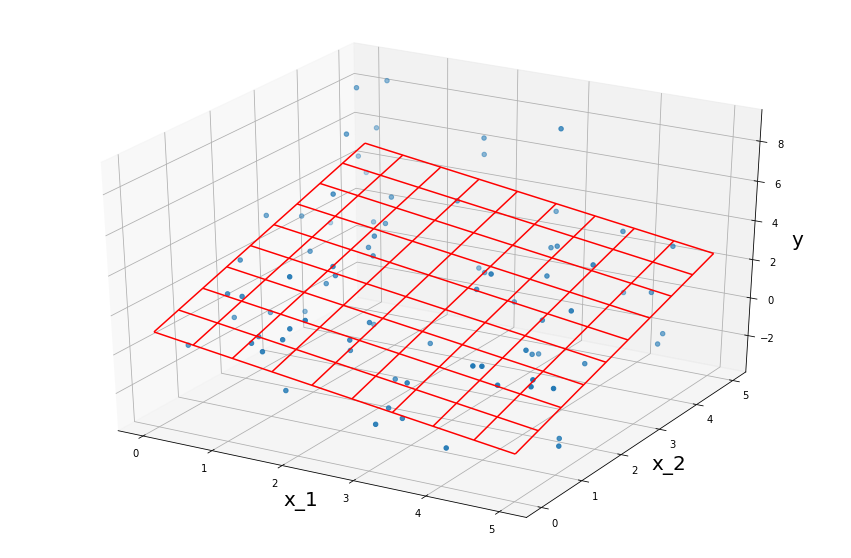

In [4]:
# plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x3[:, 1], x3[:, 2], y3)

xx = np.linspace(*DOMAIN, 10)
X, Y = np.meshgrid(xx, xx)
Z = beta_p[0] + beta_p[1] * X + beta_p[2] * Y

ax.plot_wireframe(X, Y, Z, color='r')

ax.set_xlabel('x_1', fontsize=20)
ax.set_ylabel('x_2', fontsize=20)
ax.set_zlabel('y', fontsize=20)

\\begin{align}
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon 
\\end{align}


### Ordinary least squares
The ordinary least squares approach:
$$\min \frac{1}{2}\|X \beta - y\|_2^2$$

Taking $\nabla \beta$ and setting this eqaul to zero:

\\begin{align}
X^TX\hat{\beta} - X^Ty &= 0 \\\
\hat{\beta} &= (X^TX)^{-1}X^T y
\\end{align}



### Maximum Likelihood Estimation 
If we assume $\epsilon \sim {\cal N}(0, \sigma^2 I)$, then we can show that OLS is equivalent to MLE.

The probability of a single observation:
\\begin{align}
P(y_i|X, \beta\sigma) = \frac{1}{\sqrt{2 \pi}\sigma} \exp \left(\frac{-(x_i^T\beta - y_i)^2}{2\sigma^2}\right)
\\end{align}

The probability of a given data set:
\\begin{align}
P({\cal D} | \beta, \sigma) &= \prod_i^n P(y_i|X, \beta\sigma)\\\
&\sim \prod_i^n \frac{1}{\sigma} \exp \left(\frac{-(x_i^T\beta - y_i)^2}{2\sigma^2}\right) \\\
&\sim \frac{1}{\sigma^n} \exp \left(\frac{-\\|X\beta - y\\|_2^2}{2 \sigma^2}\right),
\\end{align}

where $x_i$ is a row of $X$.

Taking the log, 

\\begin{align}
 \ln P({\cal D} | \beta, \sigma) \sim -n\ln\sigma - \frac{\\|X\beta - y\\|_2^2}{2 \sigma^2}
\\end{align}

and set $\nabla \beta$ equal to zero, we arrive at the same result.  So OLS implies a Normal error assumption, and is MLE.

Let's  implement the simple normal equations to find our coefficients, to check that this works:

In [5]:
def OLS(X, y):
    
    N, M = X.shape
    # Solve the normal equations
    A = np.linalg.inv(np.matmul(X.transpose(), X))
    beta_hat = np.matmul(A, np.matmul(X.transpose(), y))
    
    # Find the covariance 
    sig_2_hat = sum((np.matmul(X, beta_hat) - y) ** 2) / (N - M)
    beta_variance = np.diag(A) * sig_2_hat
    
    return beta_hat, beta_variance

In [6]:
beta_hat, beta_var = OLS(x3, y3)

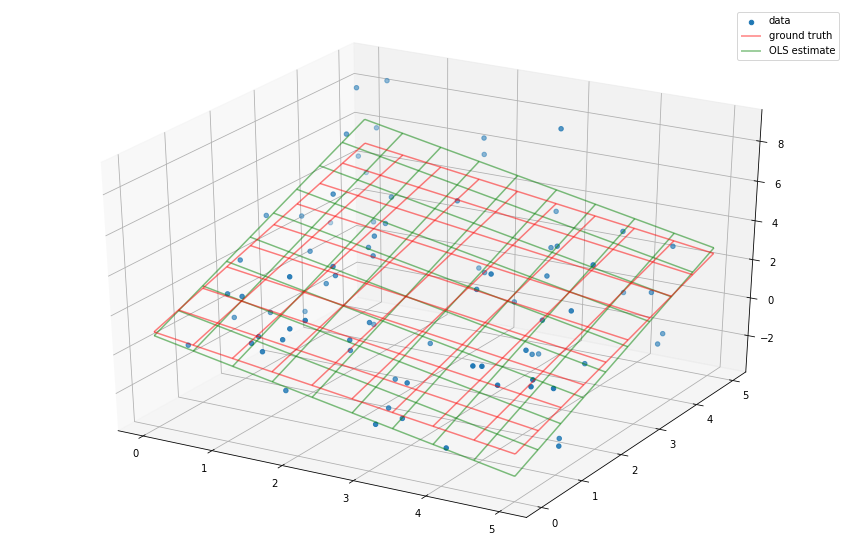

In [7]:
# plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x3[:, 1], x3[:, 2], y3, label='data')

xx = np.linspace(*DOMAIN, 10)
X, Y = np.meshgrid(xx, xx)
Z = beta_p[0] + beta_p[1] * X + beta_p[2] * Y
Z_hat = beta_hat[0] + beta_hat[1] * X + beta_hat[2] * Y


ax.plot_wireframe(X, Y, Z, color='r', label='ground truth', alpha=0.5)
ax.plot_wireframe(X, Y, Z_hat, color='g', label='OLS estimate', alpha=0.5)
ax.legend()

## Uncertainty
How should we think about the 'uncertainty' of the parameters?

Some intuition: $\beta$ is a linear transformation of the random variable $\epsilon$ (+ $y$), and so we should expect the same distribution, scaled.

The covariance matrix of $\beta$ is given by:
\\begin{align}
    V(\beta) &= \sigma^2 (X^TX)^{-1}.
\\end{align}

If we know the error variance, then $\beta$ is normally distributed.

If not,  our estimate $\hat{\sigma}^2 = \frac{\|X\hat{\beta} - y\|_2^2}{n - m}$ will follow a inverse scaled chi squarred distribution, and the 'means' $\beta$ will follow a t-distribution.

## Bayesian approach

\\begin{align}
P(\theta | {\cal D}, {\cal M}) = \frac{P(\theta| {\cal M})P({\cal D}|\theta, {\cal M})}{P({\cal D}| {\cal M})}
\\end{align}



A simple coin flipping example to illustrate the point:

In [24]:
# coin flipping
from scipy.stats import beta, binom

heads=0
tails=0

def coin_flip(n_heads, n_tails, n_flips=1):
    outcomes = np.random.uniform(size=n_flips) >= 0.5
    n_heads += outcomes.sum()
    n_tails += (~outcomes).sum()
    return n_heads, n_tails

x = np.linspace(0, 1, 100)

n_heads, n_tails = (0, 0)

Heads count: 5
Tails count: 5
MAP estimate of p: 0.494949494949495
Frequentist estiamte of p: 0.5


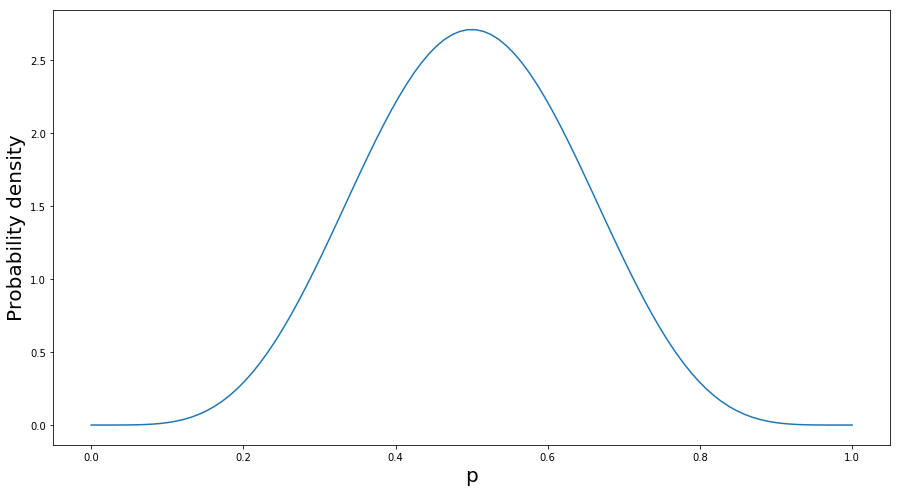

In [35]:
# EXECUTE: After viewing the prior, uncomment the following line and run this cell multiple times

n_heads, n_tails = coin_flip(n_heads, n_tails, n_flips=1)

prior_a = 1
prior_b = 1

# prior_a = 3
# prior_b = 3

pdf = beta.pdf(x, scale=1, loc=0, a=n_heads+prior_a, b=n_tails+prior_b)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
print('Heads count: {}'.format(n_heads))
print('Tails count: {}'.format(n_tails))
ax.plot(x, pdf)
ax.set_xlabel('p', fontsize=20)
ax.set_ylabel('Probability density', fontsize=20)

if (n_heads + n_tails) > 0:
    print('MAP estimate of p: {}'.format(x[pdf == pdf.max()][0]))
    print('Frequentist estiamte of p: {}'.format(n_heads / (n_heads + n_tails)))
    
    


- Distributions over parameters
- Explicitly state your assumptions (prior, and $(|, {\cal M})$
- Uncertainty at prediction level


- Model comparison using $P({\cal D} | {\cal M_i})$, and a very nice theoretical justification for occam's razor

#### Bayesian Regression

We're considering:
\\begin{align}
y|\beta, \sigma, X \sim {\cal N}(X\beta, \sigma^2I)
\\end{align}

The posterior over the parameters is proportional to the likelihood, times a prior over the parameters: 

\\begin{align}
P(\beta, \sigma | {\cal D}) \sim P(\beta, \sigma) P({\cal D} | \beta, \sigma)
\\end{align}


We already know the likelihood is given by

\\begin{align}
P({\cal D} | \beta, \sigma) \sim \frac{1}{\sigma^n} \exp \left(\frac{-\\|X\beta - y\\|_2^2}{2 \sigma^2}\right),
\\end{align}

The noninformative prior, uniform on $(\beta, \ln \sigma)$:

\\begin{align}
P(\beta, \sigma) \sim \sigma ^ {-1}
\\end{align}

leads to the same results as the frequentist approach. 

When should I use a stronger prior?
- 'few' data points
- large number of parameters


The most efficent way to do OLS regression the Bayseian way is to factor the posterior by 

\\begin{align}
P(\beta, \sigma | {\cal D}) \sim  P( \beta | \sigma, {\cal D}) P( \sigma | {\cal D})
\\end{align}

Then we can show:
\\begin{align}
\beta|\sigma, {\cal D} \sim {\cal N}(\hat{\beta}, \sigma^2V_{\beta})
\\end{align}
where once again:

\\begin{align}
\hat{\beta} &= (X^TX)^{-1}X^T y \\\
 V_{\beta} &= \sigma^2 (X^TX)^{-1}.
\\end{align}

Then we just need the marginal posterior $P(\sigma | {\cal D})$.  It turns out:

\\begin{align}
P(\sigma^2 | {\cal D}) = \frac{P(\beta, \sigma^2 | {\cal D})}{P(\beta|\sigma^2  {\cal D})} \sim \mbox{ Inv}\chi^2(n-m, s^2)
\\end{align}


\\begin{align}
s^2 = \\frac{\\|X\hat{\beta} - y\\|_2^2}{ n - m }
\\end{align}


So the MAP estimate is the same as the MLE estimate.   OLS regression is bayesian posterior inference on the linear model with a nonfinformative prior.

We can then sample from the posterior by first drawing $\sigma^2$, and then $\beta$.  


A even more general approach would be to approximate the posterior numerically, using MCMC (come to Lee's talk to find out more!), allowing us to use arbitrary error distributions.  This is way more flexible, but obviously less efficient.

- Arbitrary error (therefore likelihood) distribution, and arbitrary priors
- No need to worry about normalization constants 

In [10]:
# Regressors
class BayesianRegressor:
    def __init__(self, beta_pior_sig, gibbs_drift_rate):
        self.beta_pior_sig = beta_pior_sig
        self.g_drift = gibbs_drift_rate
        self.coef = {}
        self.p_vals = {}
        self.gibbs_sampler = Gibbs(self.posterior, self.g)
        self.coef_names = []
        self.X = None
        self.y = None
        self.N = None
        self.M = None

    @staticmethod
    def scale_prior(s):
        if s <= 0:
            return 0
        return 1 / s

    def normal_beta_prior(self, b):
        return 1 / self.beta_pior_sig * np.exp(-np.sum(b ** 2) / (2 * self.beta_pior_sig ** 2))

    def prior(self, s, b):
        return self.scale_prior(s) * self.normal_beta_prior(b)

    def likelihood(self, s, b):
        return 1 / s ** self.N * np.exp(-np.sum((np.matmul(self.X, b) - self.y) ** 2) / (2 * s ** 2))

    def posterior(self, x):
        s, b = self.split_x(x)
        return self.prior(s, b) * self.likelihood(s, b)

    def g(self, x):
        return np.random.normal(loc=x, scale=self.g_drift)

    @staticmethod
    def split_x(x):
        return x[0], x[1:]

    @staticmethod
    def comb_x(s, b):
        return np.hstack([s, b])

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.N, self.M = X.shape
        start_x = np.zeros(self.M + 1)
        start_x[0] = 1
        self.gibbs_sampler.sample(start_x)
        self.gibbs_sampler.calc_kdes()
        self.gibbs_sampler.calc_map()
        self.coef_names = ['s'] + ['b_' + str(i) for i in range(self.N)]
        self.coef.update(zip(self.coef_names, self.gibbs_sampler.map.values()))
        self.p_vals.update(zip(self.coef_names, self.calc_p_vals()))

    def calc_p_vals(self):
        pvals = np.empty(self.M + 1)
        for i, key in zip(range(self.N + 1), self.gibbs_sampler.g_kdes.keys()):
            beta = self.gibbs_sampler.map[key]
            if beta >= 0:
                lower = np.min(self.gibbs_sampler.g_kdes[key].dataset)
                pvals[i] = 2 * np.abs(self.gibbs_sampler.g_kdes[key].integrate_box_1d(lower, 0))
            else:
                high = np.max(self.gibbs_sampler.g_kdes[key].dataset)
                pvals[i] = 2 * np.abs(self.gibbs_sampler.g_kdes[key].integrate_box_1d(0, high))
        return pvals

    def summary(self):
        print('Bayesian Regression')
        print('-'*47)
        print('{:20}{:20}{:20}'.format('Parameter', 'MAP Value', 'P-value'))
        output_formatter(self.coef, self.p_vals)

    def plot(self, ax):
        cols = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
        i = 0
        coef_vals = list(self.coef.values())
        x = np.linspace(np.min(coef_vals) - 1, np.max(coef_vals) + 1, 1000)
        for c_key, g_key in zip(self.coef.keys(), self.gibbs_sampler.g_kdes.keys()):
            ax.plot(x, self.gibbs_sampler.g_kdes[g_key].evaluate(x), label=c_key + ' Bayes', c=cols[i])
            i += 1

        ax.legend()

    def map_predict(self, X):
        return np.matmul(X, np.fromiter(self.coef.values(), dtype=float)[1:])

    def sample_predict(self, X, n_samples=1):
        ind = np.random.choice(np.arange(self.gibbs_sampler.samples.shape[0]), size=n_samples)
        return np.matmul(X, self.gibbs_sampler.samples[ind, 1:].transpose())


class Gibbs:
    def __init__(self, posterior_function, sample_function):
        self.posterior_f = posterior_function
        self.sample_function = sample_function
        self.samples = None
        self.g_kdes = {}
        self.map = {}
        self.p_vals = {}

    def sample(self, start_x, n_samples=10000):
        self.samples = np.empty([n_samples, len(start_x)], dtype='float')
        indices = range(len(start_x))
        current_x = np.array(start_x, dtype='float')
        for i in range(n_samples):
            candidate_xs = self.sample_function(current_x)
            order = np.random.permutation(indices)
            for ind in order:
                candidate_x = current_x.copy()
                candidate_x[ind] = candidate_xs[ind]
                den = self.posterior_f(current_x)
                if den == 0:
                    p = 1
                else:
                    p = self.posterior_f(candidate_x) / den

                if p > np.random.uniform(0, 1):
                    current_x = candidate_x
            self.samples[i, :] = current_x

    def plot_dists(self):
        x = np.linspace(np.min(self.samples), np.max(self.samples), 1000)
        for i in self.g_kdes.keys():
            plt.plot(x, self.g_kdes[i].evaluate(x), label=i)

    def calc_kdes(self):
        for i in range(self.samples.shape[1]):
            self.g_kdes['b_' + str(i)] = gaussian_kde(self.samples[:, i])

    def calc_map(self):
        x = np.linspace(np.min(self.samples), np.max(self.samples), 1000)
        for key in self.g_kdes.keys():
            self.map[key] = x[self.g_kdes[key].evaluate(x) == np.max(self.g_kdes[key].evaluate(x))][0]

        return self.map


class OLSRegressor:
    def __init__(self, reg=0):
        self.coef = {}
        self.coef_s = {}
        self.A = None
        self.N = None
        self.M = None
        self.s2 = None
        self.t_s = None
        self.p_s = {}
        self.b = None
        self.reg = reg

    def fit(self, X, y):
        self.N, self.M = X.shape
        self.A = np.linalg.inv(np.matmul(X.transpose(), X) + self.reg * np.eye(self.M))
        self.b = np.matmul(self.A, np.matmul(X.transpose(), y))
        self.s2 = sum((np.matmul(X, self.b) - y) ** 2) / (self.N - self.M)
        coef_s = np.sqrt(self.s2 * np.diag(self.A))
        self.t_s = np.abs(self.b) / coef_s
        b_names = ['b_' + str(i) for i in range(self.N)]
        self.coef['s'] = np.sqrt(self.s2)
        self.coef.update(zip(b_names, self.b))
        self.coef_s.update(zip(b_names, coef_s))
        self.p_s.update(zip(b_names, self.calc_p_value()))

    def calc_p_value(self):
        df = self.N - self.M
        p = []
        for ts in self.t_s:
            pv = 2 * (1 - t.cdf(x=ts, df=df))
            p.append(pv)

        return p

    def summary(self):
        print('OLS Regression')
        print('-'*47)
        print('{:20}{:20}{:20}'.format('Parameter', 'MLE Value', 'P-value'))
        output_formatter(self.coef, self.p_s)

    def plot(self, ax):
        cols = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
        i = 1
        coef_vals = list(self.coef.values())
        x = np.linspace(np.min(coef_vals) - 1, np.max(coef_vals) + 1, 1000)
        ax.plot([self.coef['s'], self.coef['s']], [0, 3], label='s' + ' OLS', c=cols[0], linestyle='--')
        for key in self.coef_s.keys():
            ax.plot(x, t.pdf(x, df=self.N - 2, loc=self.coef[key], scale=self.coef_s[key]), label=key + ' OLS',
                    c=cols[i], linestyle='--')
            i += 1
        ax.legend()

    def predict(self, X):
        return np.matmul(X, self.b)
    

    
    
    
def output_formatter(b_dict, p_dict):
    keys = b_dict.keys()

    print('-'*47)
    for key in keys:
        print('{:20}{:<20.3f}{:<20.3f}'.format(key, b_dict[key], p_dict.get(key, np.nan)))
    print('-'*47)


In [11]:
np.random.seed(42)
bayesian_reg = BayesianRegressor(beta_pior_sig=50, gibbs_drift_rate=.2)
ols_reg = OLSRegressor()
bayesian_reg.fit(x3, y3)
ols_reg.fit(x3, y3)


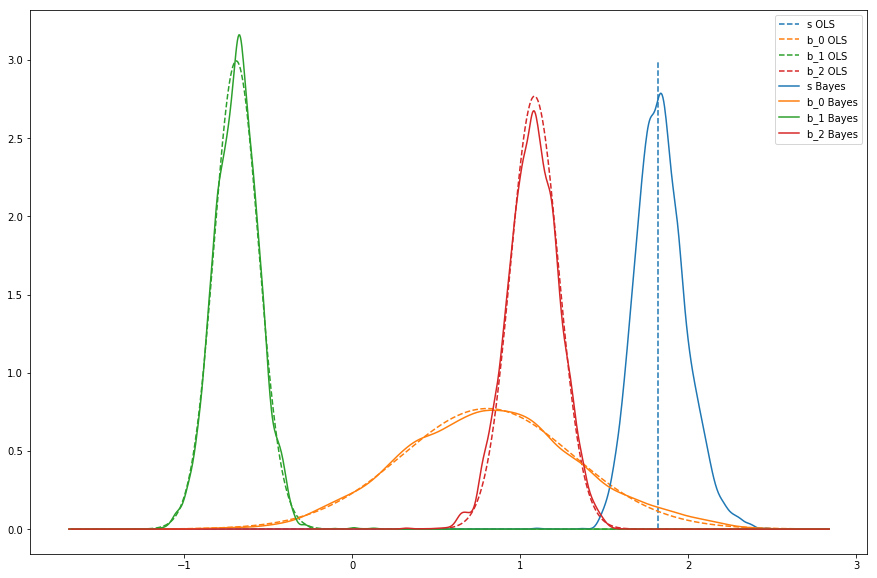

In [12]:
# plot
x = np.linspace(min(beta_hat)-.5, max(beta_hat)+.5, 500)
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
ols_reg.plot(ax)
bayesian_reg.plot(ax)
    

In [13]:
ols_reg.summary()
bayesian_reg.summary()

OLS Regression
-----------------------------------------------
Parameter           MLE Value           P-value             
-----------------------------------------------
s                   1.823               nan                 
b_0                 0.806               0.122               
b_1                 -0.689              0.000               
b_2                 1.086               0.000               
-----------------------------------------------
Bayesian Regression
-----------------------------------------------
Parameter           MAP Value           P-value             
-----------------------------------------------
s                   1.839               0.000               
b_0                 0.838               0.120               
b_1                 -0.672              0.001               
b_2                 1.083               0.000               
-----------------------------------------------


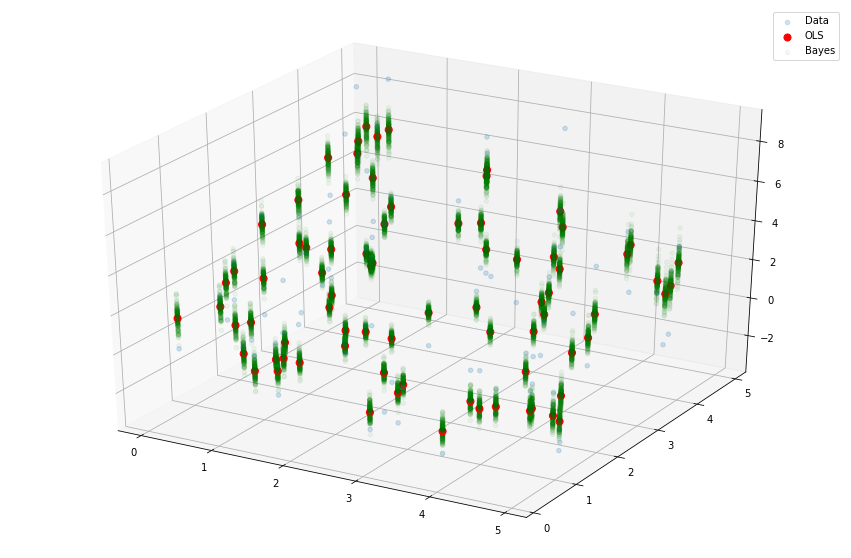

In [14]:
# plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x3[:, 1], x3[:, 2], y3, label='Data', alpha=0.2)

ax.scatter(x3[:, 1], x3[:, 2], ols_reg.predict(x3), label='OLS', c='r', zorder=0, alpha=1, s=50)

# we can do all of these at once without the for loop, this is just easier to display 
for _ in range(200):
    ax.scatter(x3[:, 1], x3[:, 2], bayesian_reg.sample_predict(x3, n_samples=1), c='g', alpha=0.05, label='Bayes')

ax.legend(['Data', 'OLS', 'Bayes'])


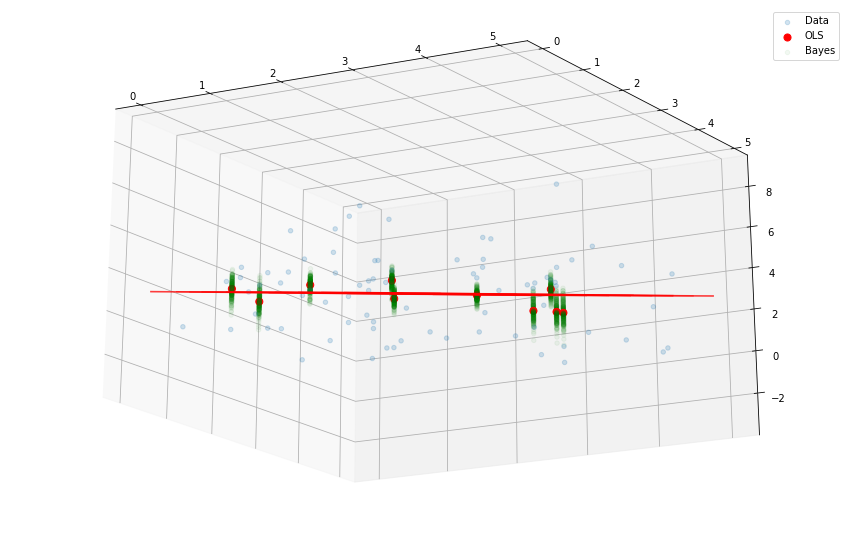

In [15]:
# plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x3[:, 1], x3[:, 2], y3, label='Data', alpha=0.2)

SUBS = 70

ax.scatter(x3[SUBS:, 1], x3[SUBS:, 2], ols_reg.predict(x3[SUBS:, :]), label='OLS', c='r', zorder=0, alpha=1, s=50)

for _ in range(200):
    ax.scatter(x3[SUBS:, 1], x3[SUBS:, 2], bayesian_reg.sample_predict(x3[SUBS:, :], n_samples=1), c='g', alpha=0.05, label='Bayes')

ax.legend(['Data', 'OLS', 'Bayes'])

xx = np.linspace(*DOMAIN, 10)
X, Y = np.meshgrid(xx, xx)
Z = beta_p[0] + beta_p[1] * X + beta_p[2] * Y
Z_hat = beta_hat[0] + beta_hat[1] * X + beta_hat[2] * Y
ax.plot_wireframe(X, Y, Z, color='r', label='ground truth', alpha=0.5)

ax.view_init(-22, -60)

## Regularization

But why?
Occam's razor: favor the simplest explanation

Trend and season example:

In [16]:
# trend example data generation
from sklearn.linear_model import Ridge

np.random.seed(10)
# have intercept, trend, and period of year
N = 12
x = np.linspace(0, 12, N)
y1 = 3 + np.sin(x) + 0.3*x

N_COPIES = 2

one_hot = np.eye(N)
X1 = np.hstack([one_hot, x[:, np.newaxis]])
X = np.tile(X1, [N_COPIES, 1])
X = X + np.random.normal(loc=0, scale=0.01, size=X.shape)
y = np.tile(y1[:, np.newaxis], [N_COPIES, 1]) + np.random.normal(loc=0, scale=0.1, size=[N*N_COPIES, 1])

In [17]:
# fit
ALPHA = 0.1
r = Ridge(alpha=ALPHA, random_state=1)
r.fit(X, y)
yp = r.predict(X1)

Text(0.5, 1.0, 'alpha 0.1')

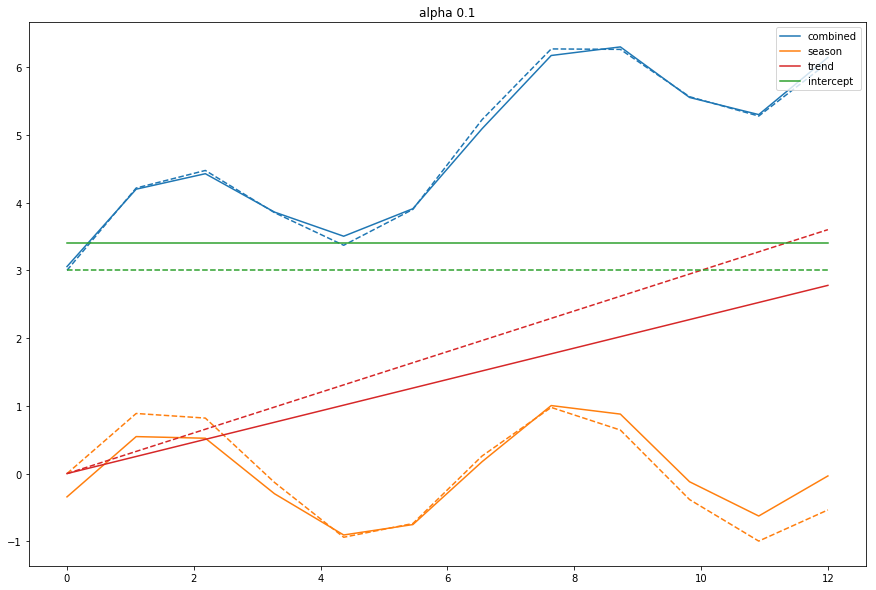

In [18]:
# plot
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

ax.plot(x, y1, color='C0', linestyle='--')
ax.plot(x, yp, label='combined', color='C0')

ax.plot(x, np.matmul(np.eye(N), r.coef_[:, :-1].transpose()), label='season', c='C1')
ax.plot(x, np.sin(x), c='C1', linestyle='--')

ax.plot(x, r.coef_[:, -1] * x, label='trend', c='C3')
ax.plot(x, 0.3 * x, c='C3', linestyle='--')


ax.plot(x, np.ones([N, 1])*r.intercept_, label='intercept', c='C2')
ax.plot(x, np.ones([N, 1])*3, c='C2', linestyle='--')
ax.legend(loc='upper right')
ax.set_title('alpha {}'.format(ALPHA))


## OLS approach

The ordinary least squares approach:
\\begin{align}
    \min \frac{1}{2}\\|X \beta - y\\|_2^2 + \frac{\lambda}{2}\\|\beta\\|_2^2
\\end{align}

leads to:
\\begin{align}
    \beta = (X^TX + \lambda I)^{-1} X^T y
\\end{align}




## Bayesian equivalent
The Bayesian equivalent is a normal prior on $\beta$: $P(\beta) \sim {\cal N}(0, \frac{\sigma^2}{\lambda})$

Remember: $P(\beta, \sigma | {\cal D}) \sim  P( \beta | \sigma, {\cal D}) P( \sigma | {\cal D})$


\\begin{align}
P(\beta| \sigma,  {\cal D} ) &\sim P(\beta)P({\cal D} | \beta, \sigma) \\\
&\sim \frac{1}{\sigma_b} \exp \left(\frac{-\\|\beta\\|_2^2}{2 \sigma_b^2}\right) \frac{1}{\sigma^n} \exp \left(\frac{-\\|X\beta - y\\|_2^2}{2 \sigma^2}\right) \\\
& \sim \frac{1}{\sigma^{n} \sigma_b} \exp \left(\frac{-\\|X\beta - y\\|_2^2}{2 \sigma^2}  -  \frac{\\|\beta\\|_2^2}{2 \sigma_b^2}\right)
\\end{align}


Taking log:
\\begin{align}
\ln P(\beta | \sigma, {\cal D} ) \sim -(n+1)\ln\sigma - \ln\sigma_b - \frac{\\|X\beta - y\\|_2^2}{2 \sigma^2}  -  \frac{\\|\beta\\|_2^2}{2 \sigma_b^2}
\\end{align}

$\nabla \beta \ln P(\beta| \sigma, {\cal D} ) = 0:$

\\begin{align}
\sigma^{-2}(X^TX\hat{\beta} - X^Ty) + \sigma_b^{-2} \hat{\beta} &= 0 \\\
\hat{\beta} &= (X^TX + \frac{\sigma^2}{\sigma_b^2}I)^{-1}X^T y
\\end{align}


So, the regularization stength $\lambda$ is equivalent to a normal prior on the parambers ${\cal N}(0, \frac{\sigma^2}{\lambda})$ (given $\sigma^2$).

In [19]:
# OLS regularization strenth 
lamb_reg = 300

In [20]:
# fit

ols_reg_r = OLSRegressor(lamb_reg)
ols_reg_r.fit(x3, y3)

bayes_reg = np.sqrt(ols_reg_r.s2 / lamb_reg)
bayesian_reg_r = BayesianRegressor(beta_pior_sig=bayes_reg, gibbs_drift_rate=.2)
bayesian_reg_r.fit(x3, y3)

print('A regularization strength of {0}, corresponds to a normal prior on the coefficients with standard deviaiton {1:1.3}'.format(lamb_reg, bayes_reg))

A regularization strength of 300, corresponds to a normal prior on the coefficients with standard deviaiton 0.129


(-1, 3)

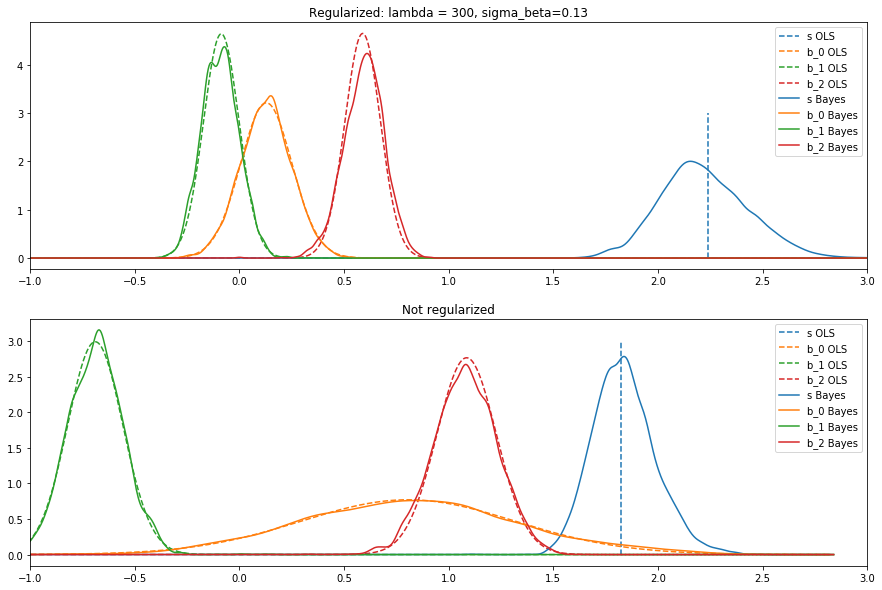

In [21]:
# plot
x = np.linspace(min(beta_hat)-.5, max(beta_hat)+.5, 500)
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
ols_reg_r.plot(ax[0])
bayesian_reg_r.plot(ax[0])

ols_reg.plot(ax[1])
bayesian_reg.plot(ax[1])

ax[0].set_title('Regularized: lambda = {0}, sigma_beta={1:1.2}'.format(lamb_reg, bayes_reg))
ax[0].set_xlim([-1, 3])

ax[1].set_title('Not regularized')
ax[1].set_xlim([-1, 3])

In [22]:
ols_reg_r.summary()
bayesian_reg_r.summary()

OLS Regression
-----------------------------------------------
Parameter           MLE Value           P-value             
-----------------------------------------------
s                   2.237               nan                 
b_0                 0.128               0.303               
b_1                 -0.087              0.313               
b_2                 0.589               0.000               
-----------------------------------------------
Bayesian Regression
-----------------------------------------------
Parameter           MAP Value           P-value             
-----------------------------------------------
s                   2.156               0.000               
b_0                 0.151               0.307               
b_1                 -0.072              0.312               
b_2                 0.609               0.000               
-----------------------------------------------


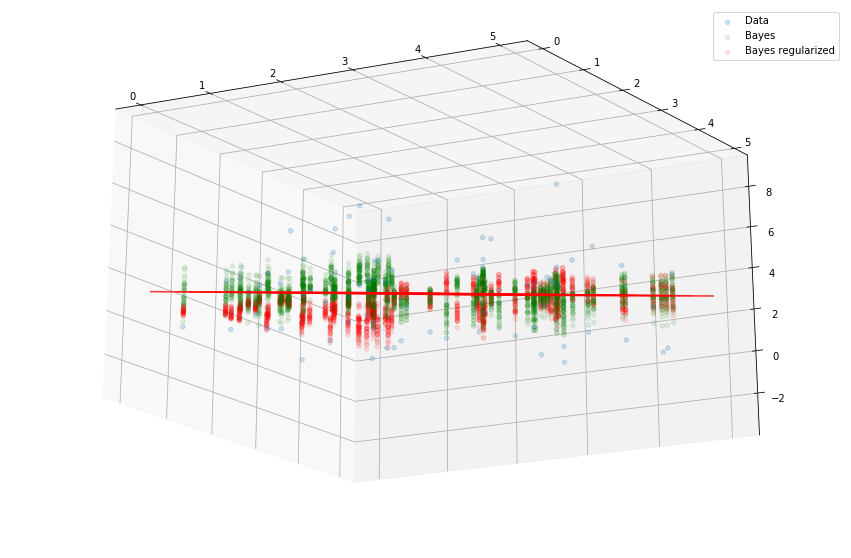

In [23]:
# plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x3[:, 1], x3[:, 2], y3, label='Data', alpha=0.2)
# ax.scatter(x3[:, 1], x3[:, 2], ols_reg.predict(x3), label='OLS', c='r', zorder=0, alpha=1, s=50)

for _ in range(30):
    ax.scatter(x3[:, 1], x3[:, 2], bayesian_reg.sample_predict(x3, n_samples=1), c='g', alpha=0.1, label='Bayes')
    ax.scatter(x3[:, 1], x3[:, 2], bayesian_reg_r.sample_predict(x3, n_samples=1), c='r', alpha=0.1, label='Bayes')

ax.legend(['Data', 'Bayes', 'Bayes regularized'])

xx = np.linspace(*DOMAIN, 10)
X, Y = np.meshgrid(xx, xx)
Z = beta_p[0] + beta_p[1] * X + beta_p[2] * Y
Z_hat = beta_hat[0] + beta_hat[1] * X + beta_hat[2] * Y


ax.plot_wireframe(X, Y, Z, color='r', label='ground truth', alpha=0.5)
ax.view_init(-22, -60)

![title](occam.png)

(from Ulrich Pachet's PhD thesis https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-724.pdf)

# Appendix

### Derivation
\\begin{align}
V(\beta)&= E\left[\left(\beta - E(\beta)\right) \left(\beta - E(\beta)\right)^T\right]
\\end{align}

Let's first consider,
\\begin{align}
  &\beta - E(\beta) \\\
  =&\beta - \hat{\beta}\\\
  =&\beta - (X^TX)^{-1}X^Ty\\\
  =&\beta - (X^TX)^{-1}X^T(X\beta + \epsilon)\\\
  =&(X^TX)^{-1}X^T\epsilon.
\\end{align}

So,
\\begin{align}
    V(\beta)&= E\left[\left((X^TX)^{-1}X^T\epsilon\right) \left((X^TX)^{-1}X^T\epsilon\right)^T\right] \\\
    &= (X^TX)^{-1}X^T E[\epsilon \epsilon^T] \left((X^TX)^{-1}X^T\right)^T.
\\end{align}
Now (because of our error assumption),
\\begin{align}
    E(\epsilon \epsilon^T) = \sigma^2 I_n.
\\end{align}
So (remember $X^TX$ is symmetric),
\\begin{align}
    V(\beta) &= \sigma^2 (X^TX)^{-1}.
\\end{align}

A much faster way to see this is to note that $\beta$ is a linear transformation of $\epsilon$, with transformation matrix $X^{-1}$, from which it follows that $V(\beta) = X^{-1} V(\epsilon) X^{-T}$.
